- Natrajvikram
- Anthony Alalam
- Yannick Kirane 

(Master of Science in AI Systems at EPITA)


### Overview:



For this the following approach has been used :

1) Train a word2vec model for generating word vectors using our own custom data corpus.



2) Use the trained word2vec model to find out similar questions (finding semantic duplicates) using cosine similarity metric. 

3) Use T-Sne to visualize word embeddings and plot similar words using the the cosine similarity between the embeddings. 


Note - For generating word2vec embeddings , I have used the entire corpus from dialogueText.csv



In [1]:
## Import all the necessary libraries and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords 
import os
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Dataset Description 

The dataset that has been used for this assignment is from Kaggle( https://www.kaggle.com/rtatman/ubuntu-dialogue-corpus) 

It is the new Ubuntu Dialogue Corpus which consists of almost one million two-person conversations extracted from the Ubuntu chat logs, used to receive technical support for various Ubuntu-related problems. The conversations have an average of 8 turns each, with a minimum of 3 turns. 

It has the following columns:
- folder: The folder that a dialogue comes from. Each file contains dialogues from one folder .
- dialogueID: An ID number for a specific dialogue. Dialogue ID’s are reused across folders.
- date: A timestamp of the time this line of dialogue was sent.
- from: The user who sent that line of dialogue.
- to: The user to whom they were replying. On the first turn of a dialogue, this field is blank.
- text: The text of that turn of dialogue, separated by double quotes (“). Line breaks (\n) have been removed.

In [3]:
df=pd.read_csv('data/dialogueText.csv')

In [4]:
df

,folder,dialogueID,date,from,to,text
0,3,126125.tsv,2008-04-23T14:55:00.000Z,bad_image,NaN,"Hello folks, please help me a bit with the fol..."
1,3,126125.tsv,2008-04-23T14:56:00.000Z,bad_image,NaN,Did I choose a bad channel? I ask because you ...
2,3,126125.tsv,2008-04-23T14:57:00.000Z,lordleemo,bad_image,the second sentence is better english and we...
3,3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,NaN,Sock Puppe?t
4,3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,NaN,WTF?
...,...,...,...,...,...,...
1038319,3,51506.tsv,2012-01-31T10:56:00.000Z,DJ,NaN,anyone on?
1038320,3,51506.tsv,2012-01-31T10:56:00.000Z,aeon-ltd,DJ,yes
1038321,3,99669.tsv,2008-11-16T20:11:00.000Z,KR-data,NaN,can I get a pastebin of someones menu.lst with...
1038322,3,99669.tsv,2008-11-16T20:12:00.000Z,outbackwifi,KR-data,http://pastebin.com/fe921690


In [5]:
df.shape

(1038324, 6)

In [6]:
df = df.drop_duplicates(['text'])

In [7]:
df = df[df['text'].notna()]

In [8]:
df.shape

(863907, 6)

# 1) Train word2vec model using custom corpus
## Data Preprocessing


Genism word2Vec requires that a format of list of list for training where every document is contained in a list and every list contains list of tokens of that document. At first, we need to generate a format of list of list for training the make model word embedding.

Before that we are going to follow these text preprocessing steps :
1. Create a new column for the preprocessed text 
2. Apply text preprocessing steps on text column : removing stopwords,removing url and email id, decontracting phrases (won't --> will not) , removing digits , removing special characters
3. Store this preprocessed text in the new column that we created earlier

In [9]:

stpwrds = stopwords.words("english") #load stopwords from nltk library


# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    #phrase = re.sub(r'^https?:\/\/.*[\r\n]*', '', phrase, flags=re.MULTILINE)
    
    return phrase





def preprocess_txt(raw_text):
    
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(raw_text):
        em_id = re.findall('\S*@\S*\s?', sentence) #find all email id
        sentence = ' '.join(e for e in sentence.split() if e not in em_id)  #remove email id tags
        
        sent = decontracted(sentence)
        
        
        
        
        sent = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sent) #remove https url
        
        
        
        
        
        sent = re.sub(r'\<[^)]*\>', '', sent)
        sent = re.sub(r'\[[^)]*\]', '', sent)
        
        



        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)   #remove all special characters using regex
        
        sent = re.sub("\d+", " ", sent)  #remove digits
        
        
        
        sent = ' '.join(e for e in sent.split() if e not in stpwrds) #remove stopwords
        
        preprocessed_text.append(sent.strip())
        
    return preprocessed_text

In [10]:
df['preprocessed_text'] = [i.lower() for i in df['text'].tolist()]

In [11]:
df['preprocessed_text'] = preprocess_txt(df['preprocessed_text'].tolist())

100%|███████████████████████████████████████████████████████████████████████| 863907/863907 [00:40<00:00, 21379.08it/s]


In [12]:
# nltk.download('punkt')

In [13]:
tok_corp = [nltk.word_tokenize(sent) for sent in tqdm(df['preprocessed_text'])]

100%|███████████████████████████████████████████████████████████████████████| 863907/863907 [01:15<00:00, 11510.99it/s]


In [14]:
tok_corp[0:5]
#sentence tokens after text preprocessing
#train data for word2vec (only the first 5 points)

[['hello',
  'folks',
  'please',
  'help',
  'bit',
  'following',
  'sentence',
  'order',
  'personal',
  'photos',
  'videos',
  'think',
  'allowed',
  'version',
  'order',
  'personal',
  'videos',
  'photos',
  'sure'],
 ['choose',
  'bad',
  'channel',
  'ask',
  'seem',
  'dumb',
  'like',
  'windows',
  'user'],
 ['second', 'sentence', 'better', 'english', 'dumb'],
 ['sock', 'puppe'],
 ['wtf']]

## Model hyperparameters: 
Let's try to understand the hyperparameter of this model.
1. size: The number of dimensions of the embeddings and the default is 100.
2. window: The maximum distance between a target word and words around the target word. The default window is 5.
3. min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
4. workers: The number of partitions during training and the default workers is 3. 
5. sg: The training algorithm, either CBOW(0) or skip gram (1). The default training alogrithm is CBOW. 

In [15]:
## Train the genisim word2vec model with our own custom corpus
model = Word2Vec(tok_corp, min_count=1,vector_size= 300,workers=3, window = 3)


INFO - 23:10:14: collecting all words and their counts
INFO - 23:10:14: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 23:10:14: PROGRESS: at sentence #10000, processed 59716 words, keeping 8013 word types
INFO - 23:10:14: PROGRESS: at sentence #20000, processed 119931 words, keeping 11867 word types
INFO - 23:10:14: PROGRESS: at sentence #30000, processed 178730 words, keeping 15012 word types
INFO - 23:10:14: PROGRESS: at sentence #40000, processed 239685 words, keeping 17841 word types
INFO - 23:10:14: PROGRESS: at sentence #50000, processed 300180 words, keeping 20231 word types
INFO - 23:10:14: PROGRESS: at sentence #60000, processed 361505 words, keeping 22561 word types
INFO - 23:10:14: PROGRESS: at sentence #70000, processed 422540 words, keeping 24713 word types
INFO - 23:10:14: PROGRESS: at sentence #80000, processed 483508 words, keeping 26715 word types
INFO - 23:10:14: PROGRESS: at sentence #90000, processed 544445 words, keeping 28540 word types


INFO - 23:10:16: PROGRESS: at sentence #840000, processed 5238038 words, keeping 111892 word types
INFO - 23:10:16: PROGRESS: at sentence #850000, processed 5301817 words, keeping 112646 word types
INFO - 23:10:17: PROGRESS: at sentence #860000, processed 5365006 words, keeping 113454 word types
INFO - 23:10:17: collected 113758 word types from a corpus of 5389604 raw words and 863907 sentences
INFO - 23:10:17: Creating a fresh vocabulary
INFO - 23:10:17: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 113758 unique words (100.00% of original 113758, drops 0)', 'datetime': '2022-06-20T23:10:17.669506', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO - 23:10:17: Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 5389604 word corpus (100.00% of original 5389604, drops 0)', 'datetime': '2022-06-20T23:10:17.670512', 'gensim': '4.2.0', 'pytho

### Save the trained word2vec model

In [31]:
if not os.path.exists('models/'):
    os.mkdir('models/')
model.save("models/word2vec.model") #save the trained model

INFO - 23:19:02: Word2Vec lifecycle event {'fname_or_handle': 'models/word2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-06-20T23:19:02.618372', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'saving'}
INFO - 23:19:02: storing np array 'vectors' to models/word2vec.model.wv.vectors.npy
INFO - 23:19:02: storing np array 'syn1neg' to models/word2vec.model.syn1neg.npy
INFO - 23:19:02: not storing attribute cum_table
INFO - 23:19:03: saved models/word2vec.model


### Generating sentence embeddings and dealing with out of vocabulary words:

- Word2vec can only give the word vectors/embeddings and not sentence embeddings directly. In order to generate sentence embeddings we average the word vectors present in the sentence and get the sentence embeddings. (average word2vec) 
- for words which are outside the vocabulary of what word2vec was trained with , the sentence embedding for that  is just a 300 dimensional numpy array with zeros inside.

In [4]:
def sent_embedding_w2v(sentence): #input sentence, output - sentence embedding (average word2vec)

    sentence = preprocess_txt([sentence.lower()])[0]

    words = sentence.split()
    
    emb = []
    for word in words:
        try:
            wrd_emb = model.wv[word]
#             print(word)
            
        except:
            print('oov',word)    
            wrd_emb = np.zeros(300)

        emb.append(wrd_emb)
    emb = np.array(emb)
    sent_vect = np.mean(emb,axis=0)
    return sent_vect

### Load the saved word2vec model 

In [1]:
from gensim.models import Word2Vec
model = Word2Vec.load("models/word2vec.model")

# Compare Similarities of two words using the trained model

Now we could even use Word2vec to compute similarity between two make model in the vocabulary by invoking the model.wv.similarity() and passing in the relvevant words.  This will give us the cosine similarity between two words. 

In [4]:
model.wv.similarity('pc', 'computer')

0.82198954

In [5]:
model.wv.similarity('debian', 'fedora')

0.68565875

In [6]:
model.wv.similarity('system', 'computer')

0.61230266

In [7]:
model.wv.most_similar('pc')[:5]

[('computer', 0.8219895362854004),
 ('machine', 0.7859145402908325),
 ('comp', 0.7605471014976501),
 ('laptop', 0.7427248954772949),
 ('computers', 0.6521255373954773)]

In [8]:
model.wv.most_similar('computer')[:5]

[('pc', 0.8219894766807556),
 ('machine', 0.7888655066490173),
 ('comp', 0.7796912789344788),
 ('laptop', 0.7036179900169373),
 ('computers', 0.6514057517051697)]

In [9]:
model.wv.most_similar('fedora')[:10]

[('slackware', 0.8008060455322266),
 ('suse', 0.7971141338348389),
 ('opensuse', 0.7698808312416077),
 ('redhat', 0.7678236961364746),
 ('gentoo', 0.7550193667411804),
 ('mandrake', 0.7549541592597961),
 ('mandriva', 0.7300053834915161),
 ('freebsd', 0.6956437230110168),
 ('centos', 0.6900131702423096),
 ('debian', 0.6856587529182434)]

In [10]:
model.wv.most_similar('system')[:10]

[('systems', 0.732359766960144),
 ('computer', 0.6123026013374329),
 ('isystem', 0.5721561312675476),
 ('sys', 0.5573136806488037),
 ('machine', 0.5495628118515015),
 ('centralize', 0.5164429545402527),
 ('sytem', 0.5087201595306396),
 ('pc', 0.48866644501686096),
 ('os', 0.4869672358036041),
 ('upon', 0.47061389684677124)]

In [11]:
model.wv.most_similar('debian')[:10]

[('redhat', 0.7087666392326355),
 ('gentoo', 0.6986042857170105),
 ('fedora', 0.6856587529182434),
 ('slackware', 0.656401515007019),
 ('centos', 0.6519718170166016),
 ('sid', 0.6517660617828369),
 ('suse', 0.6203895211219788),
 ('sarge', 0.6125208735466003),
 ('arch', 0.58791184425354),
 ('mandrake', 0.5827170014381409)]

In [12]:
model.wv.most_similar('linux')[:10]

[('nix', 0.6492409706115723),
 ('ubuntu', 0.5878258943557739),
 ('os', 0.5544647574424744),
 ('unix', 0.530935525894165),
 ('microsoft', 0.5148161053657532),
 ('osx', 0.5119789242744446),
 ('bsd', 0.5113389492034912),
 ('ms', 0.5103245973587036),
 ('xp', 0.4757663607597351),
 ('windows', 0.47441938519477844)]

# T-SNE Plot

It’s hard to visualize the word embedding directly, for they usually has more than 3 dimensions. T-SNE is an useful tool to visualize high-dimensional data by reducing dimensional space while keeping relative pairwise distance between points. It can be said that t-SNE looking for a new data representation where the neighborhood relations are preserved.  The following code showed how to plot the word embedding with T-SNE plot. 

In [5]:
#https://www.kaggle.com/code/achintyatripathi/gensim-word2vec-usage-with-t-sne-plot/notebook

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    print(close_words)
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line],
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word))

In [4]:
list(model.wv.key_to_index.keys())

['ubuntu',
 'install',
 'get',
 'use',
 'know',
 'anyone',
 'help',
 'like',
 'need',
 'would',
 'try',
 'one',
 'want',
 'linux',
 'file',
 'windows',
 'using',
 'installed',
 'work',
 'hi',
 'apt',
 'way',
 'run',
 'system',
 'sudo',
 'command',
 'see',
 'server',
 'cd',
 'think',
 'boot',
 'problem',
 'find',
 'x',
 'gnome',
 'thanks',
 'make',
 'could',
 'good',
 'question',
 'files',
 'etc',
 'desktop',
 'new',
 'something',
 'package',
 'trying',
 'right',
 'someone',
 'yes',
 'please',
 'running',
 'hey',
 'terminal',
 'got',
 'version',
 'go',
 'partition',
 'sure',
 'time',
 'well',
 'tried',
 'im',
 'tell',
 'grub',
 'drive',
 'check',
 'hello',
 'change',
 'root',
 'set',
 'bit',
 'channel',
 'guys',
 'ok',
 'program',
 'card',
 'user',
 'open',
 'ask',
 'kernel',
 'still',
 'update',
 'upgrade',
 'default',
 'error',
 'working',
 'also',
 'screen',
 'dont',
 'works',
 'network',
 'support',
 'really',
 'add',
 'look',
 'mean',
 'firefox',
 'used',
 'manager',
 'start',
 'us

In [6]:
# model.wv['module']

In [6]:
keys = ['linux',
 'java',
 'memory',
 'address',
 'configuration',
 'plugins',
 'pc',
 'mac']

In [7]:
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [13]:
word_clusters[0:2]

[['nix',
  'ubuntu',
  'os',
  'unix',
  'microsoft',
  'osx',
  'bsd',
  'ms',
  'xp',
  'windows',
  'operating',
  'freebsd',
  'vista',
  'fedora',
  'modern',
  'windoze',
  'inudz',
  'natively',
  'course',
  'ubunto',
  'dos',
  'mac',
  'conveniences',
  'gentoo',
  'apple',
  'kimo',
  'schilli',
  'older',
  'systems',
  'disencourage'],
 ['jre',
  'jdk',
  'openjdk',
  'jvm',
  'sun',
  'eclipse',
  'icedtea',
  'microsystem',
  'oracle',
  'runtime',
  'shepherding',
  'blackdown',
  'gcj',
  'flashplayer',
  'azureus',
  'opera',
  'netbeans',
  'frostwire',
  'ruby',
  'ddownload',
  'javac',
  'microsystems',
  'sdk',
  'chromium',
  'mozilla',
  'gij',
  'storagetek',
  'masterofdisaster',
  'limewire',
  'niagras']]

In [14]:
embedding_clusters[0:10]

array([[[-2.32719302e-01,  4.62321907e-01, -4.17468578e-01, ...,
         -2.05311164e-01,  1.77744359e-01,  3.07751745e-01],
        [-1.13452971e+00,  2.30924487e-02, -2.68365681e-01, ...,
          2.55642802e-01,  1.13685966e+00, -1.32704973e+00],
        [-6.27557874e-01,  6.54078543e-01, -4.69530255e-01, ...,
         -7.68944979e-01,  9.02983785e-01, -9.12607193e-01],
        ...,
        [-3.49329114e-01, -3.18278670e-02,  1.09682061e-01, ...,
         -3.74417678e-02,  3.09274852e-01, -3.30555677e-01],
        [-7.04198778e-02,  8.31894875e-01, -8.90219033e-01, ...,
         -8.62023890e-01,  1.18030325e-01,  2.42804110e-01],
        [-8.24217405e-03,  2.39275908e-03, -1.10534420e-02, ...,
         -5.87590644e-03,  5.06550353e-03,  4.58794041e-03]],

       [[-2.30159879e-01, -1.61374599e-01,  7.72336781e-01, ...,
          1.03195854e-01,  3.60632002e-01, -8.86779204e-02],
        [-1.14244297e-01, -3.59659970e-01,  3.68617743e-01, ...,
          2.77099133e-01,  1.54396936e

In [8]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

WARNING - 22:48:38: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 22:48:38: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 22:48:38: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for a

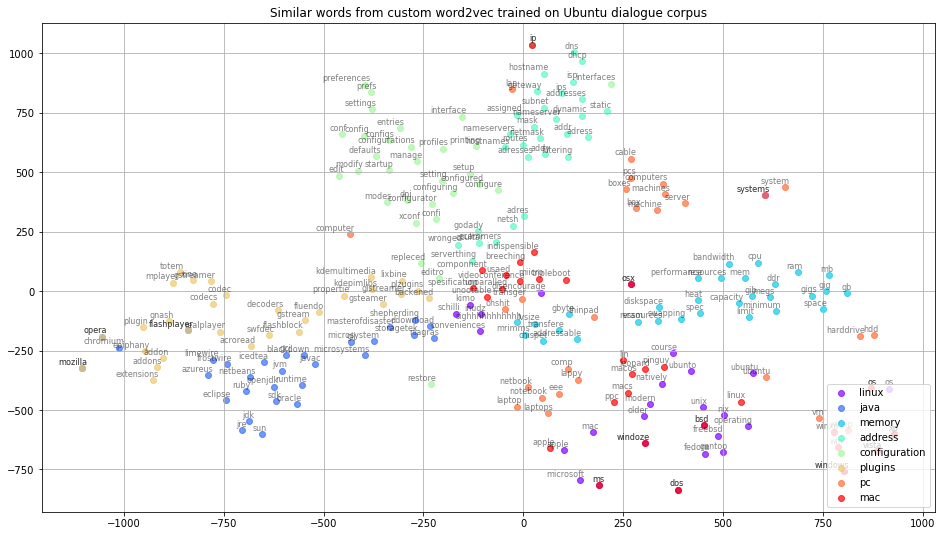

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from custom word2vec trained on Ubuntu dialogue corpus', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

### Representation:

- Blue: most similar
- Green: least similar
- Values: cosine similarity score


[('jre', 0.7581955194473267), ('jdk', 0.7451823949813843), ('openjdk', 0.7181538343429565), ('jvm', 0.713223397731781), ('sun', 0.7025538682937622), ('eclipse', 0.6839101314544678), ('icedtea', 0.6738424897193909), ('microsystem', 0.6284152865409851), ('oracle', 0.62509685754776), ('runtime', 0.6236280202865601)]


<IPython.core.display.Javascript object>


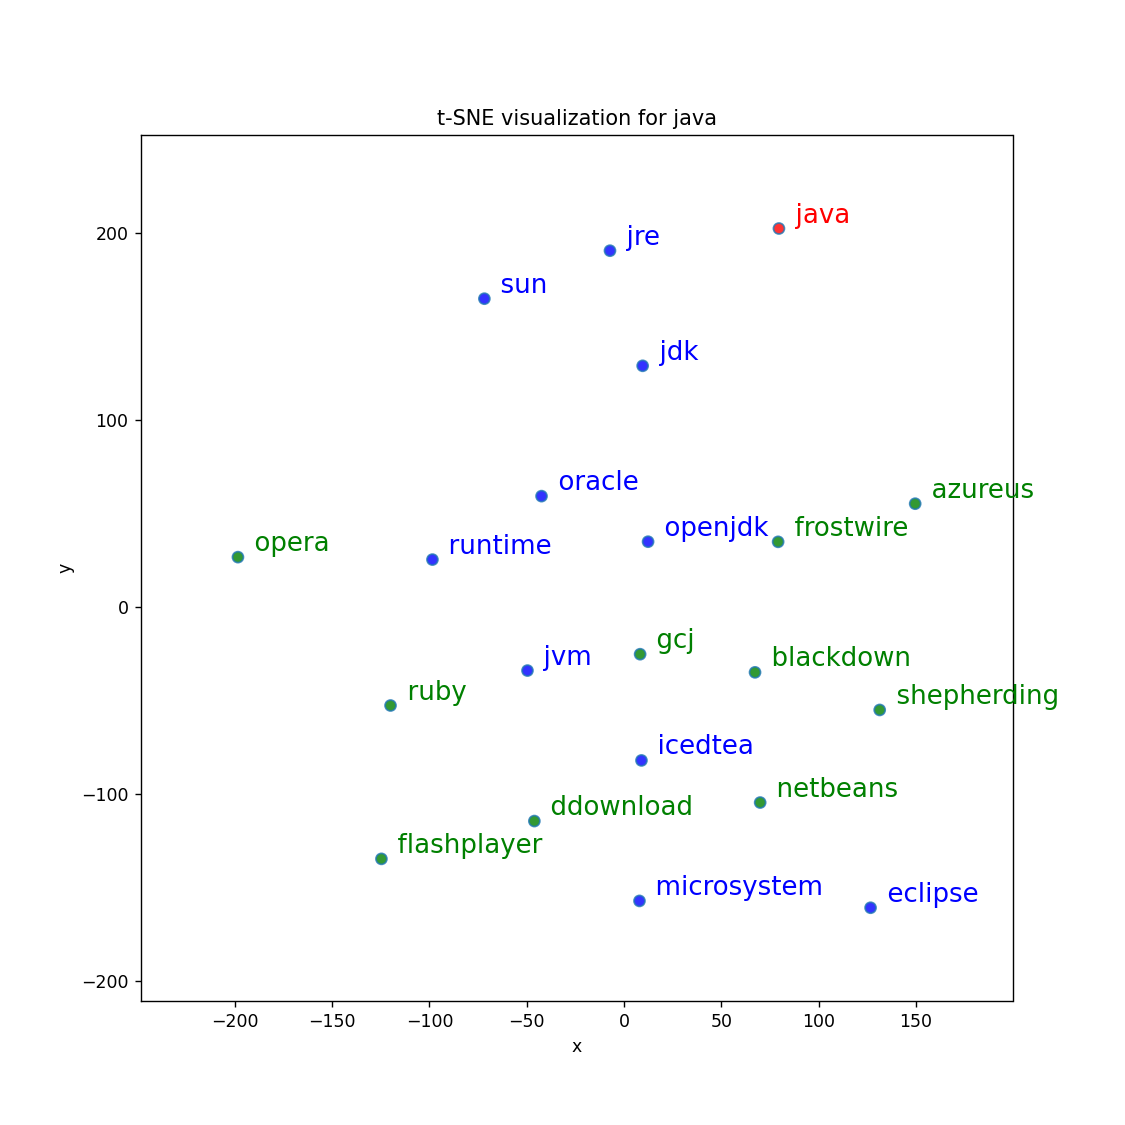

In [50]:
tsnescatterplot(model, 'java',[t[0] for t in model.wv.most_similar(positive=["java"], topn=20)][10:])

[('ubunto', 0.6563655138015747), ('linux', 0.5878258347511292), ('os', 0.5765936970710754), ('unbuntu', 0.5709099173545837), ('currently', 0.5612027645111084), ('xubuntu', 0.558449923992157), ('however', 0.5349221229553223), ('xp', 0.5182011723518372), ('fully', 0.5170345902442932), ('kubuntu', 0.5151200294494629)]


<IPython.core.display.Javascript object>


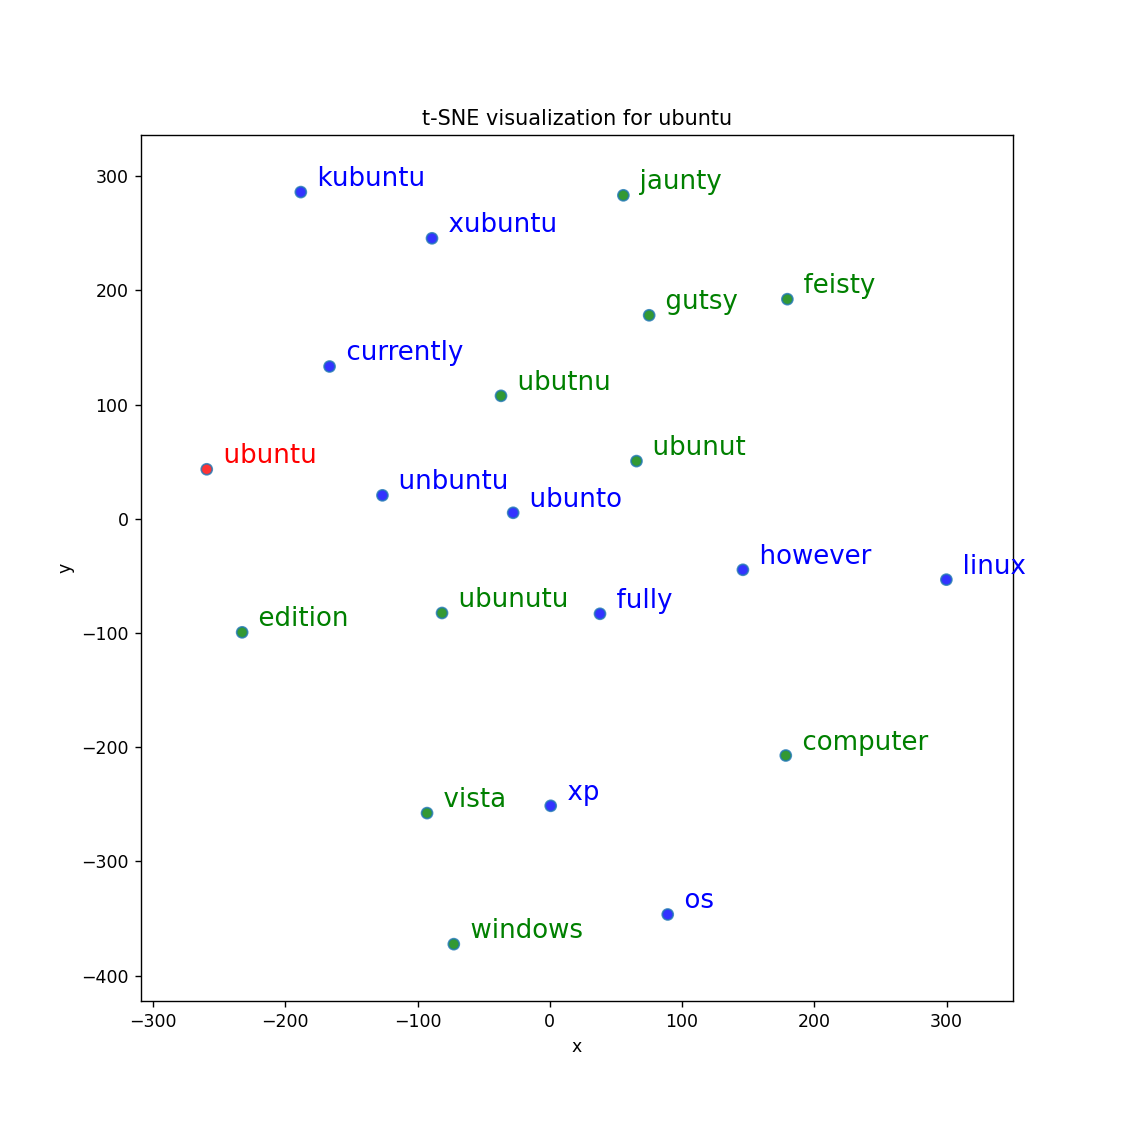

In [51]:
tsnescatterplot(model, 'ubuntu',[t[0] for t in model.wv.most_similar(positive=["ubuntu"], topn=20)][10:])

[('redhat', 0.7087666392326355), ('gentoo', 0.6986042857170105), ('fedora', 0.6856587529182434), ('slackware', 0.656401515007019), ('centos', 0.6519718170166016), ('sid', 0.6517660617828369), ('suse', 0.6203895211219788), ('sarge', 0.6125208735466003), ('arch', 0.58791184425354), ('mandrake', 0.5827170014381409)]


<IPython.core.display.Javascript object>


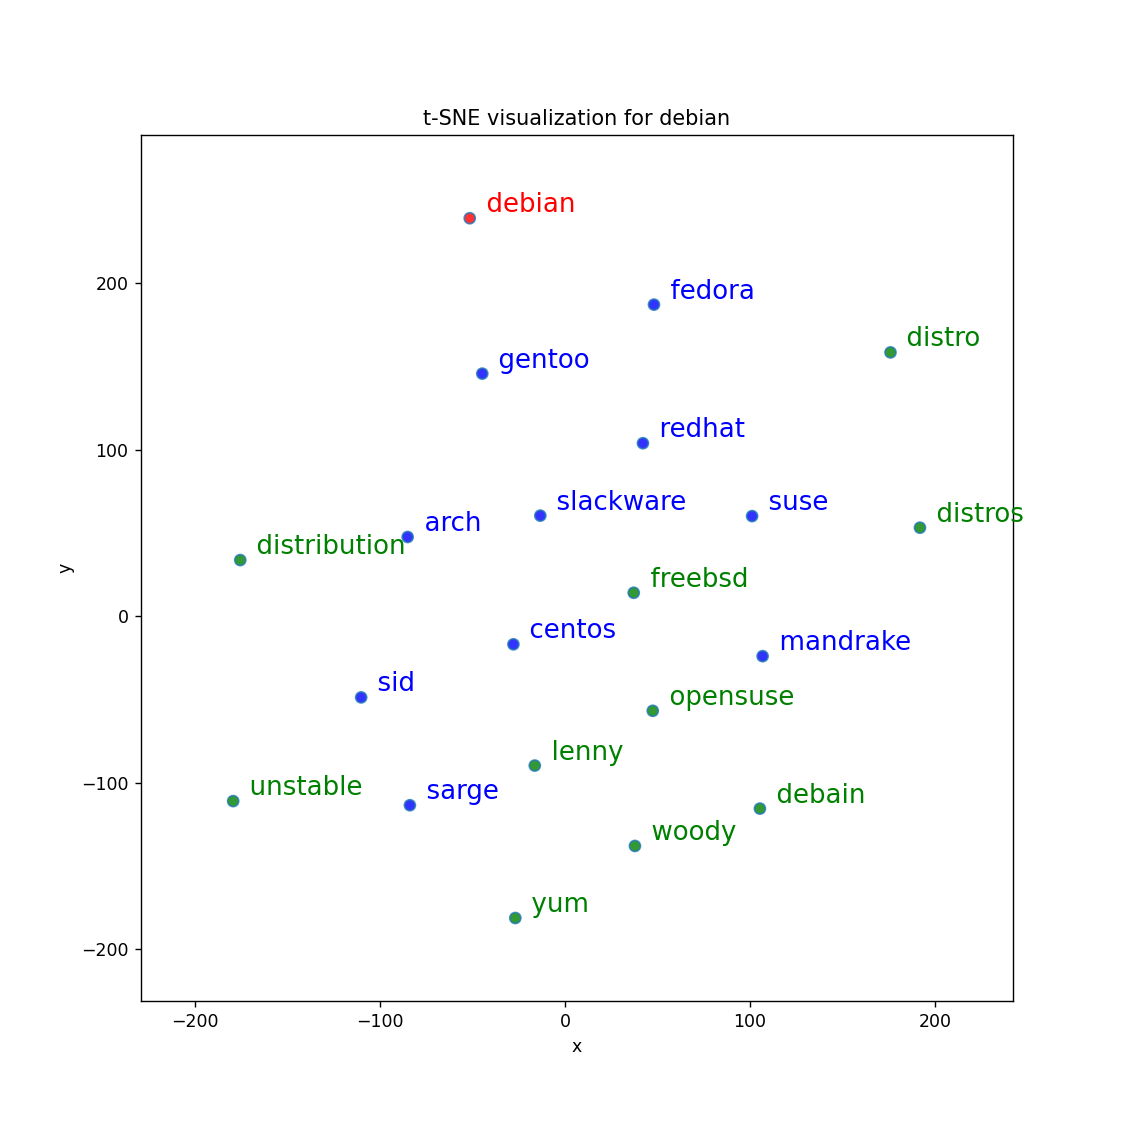

In [52]:
tsnescatterplot(model, 'debian',[t[0] for t in model.wv.most_similar(positive=["debian"], topn=20)][10:])

[('computer', 0.8219895362854004), ('machine', 0.7859145402908325), ('comp', 0.7605471014976501), ('laptop', 0.7427248954772949), ('computers', 0.6521255373954773), ('pcs', 0.6408607959747314), ('machines', 0.6283248066902161), ('box', 0.6239096522331238), ('notebook', 0.59477698802948), ('xp', 0.5703235268592834)]


<IPython.core.display.Javascript object>


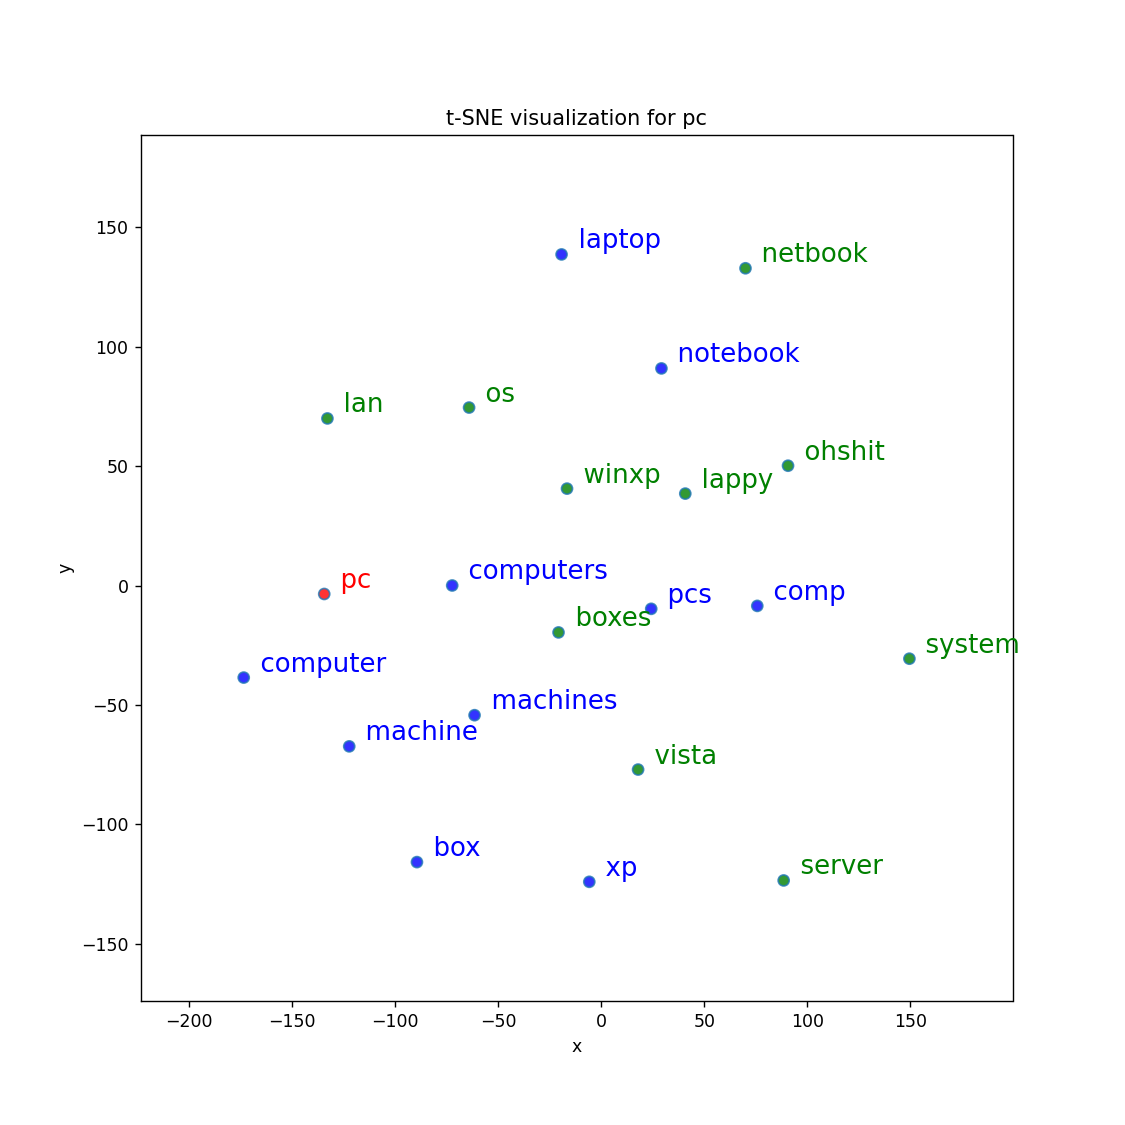

In [56]:
tsnescatterplot(model, 'pc',[t[0] for t in model.wv.most_similar(positive=["pc"], topn=20)][10:])

### Observations:
- The trained word2vec model is able fetch pretty good embeddings and find similar words based on cosine similarity measure.